A quick overview of the data
============================

Let’s start this tutorial with a quick overview of what the GRAVITY data
look like. The document only deal with dual-field data (as opposed to
single-field), at the “astrored” reduction level (so, not the fully
pipeline-reduced “scivis” data). There are a couple of important
differences between “astrored” data and “scivis”: in the “astrored”, the
DITs are kept separate, whereas to create the “scivis”, the pipeline
average them; and in “astrored” files, the phase of the visibility is
not corrected for fringe-tracker referencing, dispersion correction,
non-common path error correction, etc.). The exoGravity pipeline is
based on those dual-field astrored data products.

Two example data file are provided with this tutorial, which correspond
to the same exposure made on 51 Eri, during the night of Nov, 11, 2019.
The difference between those two files is that one of them contains a
few extra corrections data.

-   Pipeline reduced “astrored”:
    `GRAVI.2019-11-11T06:29:03.495_astroreduced.fits`

-   With additional info from Sylvestre:
    `GRAVI.2019-11-11T06:29:03.495_astroreduced_s.fits`

To look at what is inside these data files, you can open one of them
files with “fv”[1] (see
Figure <a href="#fig:fv" data-reference-type="ref" data-reference="fig:fv">1</a>)

<figure>
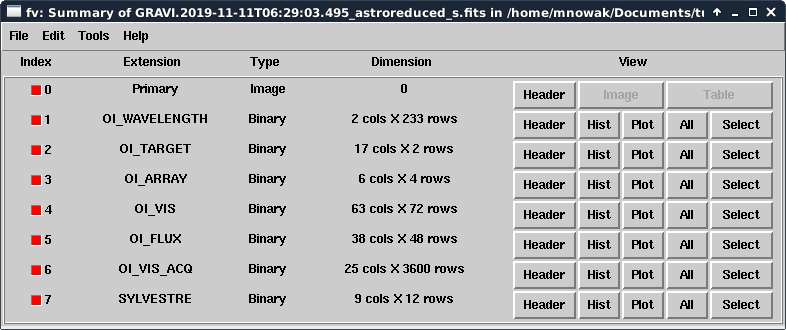<figcaption>A GRAVITY data file opened with “fv”, where the different OIs contained in the FITS file are displayed.<span label="fig:fv"></span></figcaption>
</figure>

Each file is divided in different “OIs”, which contain different fields.
Here are the data which are the most useful for exoGravity:

-   Primary header: The main header contains several useful
    inforoamtion. Some of the not-so-obvious are: `SOBJ X` and `SOBJ Y`,
    which give the position of the science fiber with respect to the FT
    fiber (RA/DEC, in mas); `SOBJ SWAP` tells whether or not the
    exposure is done at the swapped position; `DET2 SEQ1 DIT` and
    `NDIT OBJECT` give the integration time (for one DIT, in s), and the
    number of DITs in the exposure file

-   `OI_WAVELENGTH`: `EFF_WAV` contains the wavelength grid, in meters

-   `OI_TARGET`: Not used

-   `OI_ARRAY`: Not used

-   `OI_VIS`: contains the visibiliy (or baseline-based) data. In
    particular, `VISDATA` contain the complex raw visibilities as
    extracted by the pipeline, and `VISERR` contain the error on the
    real and imaginary parts of the `VISDATA`. `UCOORD` and `VCOORD`
    contain the UV coordinates of the baselines, in meters. `PHASE_REF`
    contains the phase reference point of the Fringe-Tracker, and
    `OPD_DISP` contain the OPD dispersion correction

-   `OI_FLUX`: contains the flux data, and some important
    telescope-based quantities related to the metrology correction.
    `FLUX` and `FLUXERR` give the flux and the associated error bars.
    The two quantities `OPD_MET_TELFC_MCORR` and `OPD_MET_FC_CORR` are
    used for the metrology correction (non-common path errors)

-   `OI_VIS_ACQ`: Not used

-   `SYLVESTRE`: only present in the `_s.fits` file, this extension
    contains data used for alternative OPD dispersion and metrology
    corrections

The cleanGravity package
========================

Load a file
-----------

To simplify the manipulation of the data, a dedicated package is
provided with the exoGravity pipeline: `cleanGravity`. The aim of that
package is to provide an Python object-oriented interface to the GRAVITY
data.

Different classes are defined, to fit the specificity of the different
GRAVITY file products:

-   `GravityDualscivisAstrored`

-   `GravitySinglefieldsAstrored`

-   `GravityDualfieldScivis`

-   `GravitySinglefieldScivis`

In the exoGravity pipeline, only `GravityDualfieldAstrored` objects are
used. The syntax to load a file into on of these objects is always
similar. In the most basic form, you only need to specify the name of
the FITS file to load, as well as the extension (when you have different
polarizations, you have different extensions):

[1] https://heasarc.gsfc.nasa.gov/ftools/fv/

In [ ]:
# load a file with cleanGravity
import cleanGravity as cg
oi = cg.GravityDualfieldAstrored("./data/GRAVI.2019-11-11T06:29:03.495_astroreduced.fits", extension = 10)

When the `GravityOi` object is created, several attributes are created:

-   `oi.header` is an astropy object, which contain the main header

-   `oi.visOi` contains the data from the `OI_VIS`. It is a `visOi`
    object, as defined in the `cleanGravity` package

-   `oi.fluxOi` contains the data from the `FLUX_VIS`, in a `fluxOi`
    object

-   Several useful attributes are also loaded from the header, like
    `oi.sObjX` and `oi.sObjY` (position of the fiber), `oi.mjd` (time of
    observation), etc. Please refer to the documentation of the package

Once the `GravityOi` object is created, the different data sets are
automatically loaded and reshaped in numpy arrays, complex or reals
(depending on the data). The shape of these arrays is always:
$$\text{Shape of the numpy data arrays in cleanGravity:} \qquad \left[n_\mathrm{DIT}, n_\mathrm{channels}, n_\mathrm{wav}\right]$$
Where $n_\mathrm{DIT}$ is the number of DITs in the exposure file,
$n_\mathrm{channels}$ the number of channels in the OI (4 channels
corresponding to 4 telescopes in the `FLUX_OI`, 6 channels for 6
baselines in `VIS_OI`), and $n_\mathrm{wav}$ corresponds to the number
of wavelength points.

For example:

In [ ]:
# print the shape of visibility data
print("Visibility data array is of shape {}".format(oi.visOi.visData.shape))

As another example, you can plot the flux on each telescope as a
function of wavelength using something like:

In [ ]:
# plot the flux on each telescope
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(12, 8))
for k in range(oi.fluxOi.nchannel):
    ax = fig.add_subplot(2, 2, k+1)
    ax.plot(oi.wav*1e6, oi.fluxOi.flux[0, k, :])
    ax.set_xlabel("Wavelength ($\mu$m)")
    ax.set_ylabel("Flux (ADU/s)")
    ax.set_title("Flux of DIT=0 for telescope {}".format(oi.telnames[k]))
plt.show()

Plotting with gravityPlot
-------------------------

The visibility data contained in `oi.visOi.visData` are complex numbers.
To plot them, you need to separate real/imaginary, modulus/phase, or use
3D graphs. To make things easier for a quick view at the data, the
`cleanGravity` also provides some plotting functions. These are not
automatically loaded at the import of the package, to allow for changing
the configuation of `matplotlib` if needed, before importing the plot
functions. You can import these functions, and plot the visibilities in
real/imaginary parts using:

In [ ]:
# plot visibilities using cleanGravity.gravityPlot
from cleanGravity import gravityPlot as gplot
import numpy as np
gplot.reImPlot(np.tile(oi.wav, (oi.visOi.nchannel, 1)), oi.visOi.visData[0, :, :], subtitles = oi.basenames)

The `modPhasePlot` function does the same thing, but in modulus/phase
instead of real/imaginary parts. You can also plot a real quantity over
several channels at once using the `baselinePlot` function. For example,
instead of looping over the telescopes to plot the flux, you can use the
one-liner:

In [ ]:
# for purely real data (like the flux)
gplot.baselinePlot(np.tile(oi.wav, (oi.fluxOi.nchannel, 1)), oi.fluxOi.flux[0, :, :], subtitles = oi.telnames)

Standard phase corrections
--------------------------

The `cleanGravity` package also provides methods to apply the phase
corrections to the “astrored” data. The FT referencing is automatically
applied when the data are loaded, and the resulting “FT referenced”
visibilities are available in `oi.visOi.visRef`. To apply the OPD
dispersion correction, just call `oi.corrDisp()`, or
`oi.corrDispSylvestre()`, if you want to use the Sylvestre special
correction (only with a `_s.fits` file). Similarly, to apply the
metrology (non common path) correction, call `oi.corrMet()`, or
`oi.corrMetSylvestre()`.

The phase corrections are always performed on the `oi.visOi.visRef`
arrays. The `oi.visOi.visData` stays at the initial values, which give
the raw visibilities.

These corrections can be automatically applied when loading the data, by
setting the `corrDisp` or `corrMet` kwargs:

In [ ]:
# apply phase corrections when loading the file
oi = cg.GravityDualfieldAstrored("./data/GRAVI.2019-11-11T06:29:03.495_astroreduced.fits", extension = 10, corrDisp = "drs", corrMet = "drs")